## EDA Objective
本分析では、店舗および商品カテゴリ別の売上構造を理解し、
価格・割引・ロイヤルティ施策が売上数量に与える影響の傾向を把握する。

特に以下を明らかにすることを目的とする：
- 店舗・商品カテゴリごとの売上分布とばらつき
- 価格・割引率・ポイント施策と売上数量の関係性
- 時系列的なトレンドや季節性の有無

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)

df = pd.read_csv("../data/raw/grocery_chain_data.csv")  # ファイル名は合わせて

# データの基本情報
print("shape:", df.shape)
display(df.head())

# 型の確認
display(df.dtypes)

# 欠損値の確認
print(df.isnull().sum())


shape: (1980, 11)


,customer_id,store_name,transaction_date,aisle,product_name,quantity,unit_price,total_amount,discount_amount,final_amount,loyalty_points
0,2824,GreenGrocer Plaza,2023-08-26,Produce,Pasta,2.0,7.46,14.92,0.00,14.92,377
1,5506,ValuePlus Market,2024-02-13,Dairy,Cheese,1.0,1.85,1.85,3.41,-1.56,111
2,4657,ValuePlus Market,2023-11-23,Bakery,Onions,4.0,7.38,29.52,4.04,25.48,301
3,2679,SuperSave Central,2025-01-13,Snacks & Candy,Cereal,3.0,5.50,16.50,1.37,15.13,490
4,9935,GreenGrocer Plaza,2023-10-13,Canned Goods,Orange Juice,5.0,8.66,43.30,1.50,41.80,22


customer_id           int64
store_name           object
transaction_date     object
aisle                object
product_name         object
quantity            float64
unit_price          float64
total_amount        float64
discount_amount     float64
final_amount        float64
loyalty_points        int64
dtype: object

customer_id          0
store_name          25
transaction_date     0
aisle                0
product_name         0
quantity             0
unit_price           0
total_amount         0
discount_amount      0
final_amount         0
loyalty_points       0
dtype: int64


### data check
- サンプル数: 1980
- 特徴量数: 11 
- 日付カラムは object 型 → datetime 変換が必要
- store_name に欠損あり → 補完 or 除外の検討が必要
- カテゴリ変数はエンコーディングが必要


In [3]:
# 欠損率（%）
missing = df.isna().mean().sort_values(ascending=False) * 100
display(missing[missing > 0].round(2))

# 基本統計（数値）
display(df.describe(include='all').T)


store_name    1.26
dtype: float64

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,1980.0,NaN,NaN,NaN,5542.958081,2575.771856,1006.0,3271.5,5582.5,7791.75,9998.0
store_name,1955,9,City Fresh Store,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transaction_date,1980,689,2023-10-18,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aisle,1980,11,Beverages,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,1980,18,Chicken Breast,131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,1980.0,NaN,NaN,NaN,2.968182,1.419028,1.0,2.0,3.0,4.0,5.0
unit_price,1980.0,NaN,NaN,NaN,15.488045,8.400823,0.99,8.24,15.19,22.8625,29.98
total_amount,1980.0,NaN,NaN,NaN,45.902576,35.018599,1.01,18.0,37.13,67.93,149.9
discount_amount,1980.0,NaN,NaN,NaN,4.469591,4.962001,0.0,1.24,3.045,5.4025,29.94
final_amount,1980.0,NaN,NaN,NaN,41.432985,32.593328,-3.43,15.8,32.82,60.8,147.91


## Findings
- store_name の欠損は全体の 1.26% と限定的である。
- total_amount,discount_amount,final_amountは平均値が中央値を上回っており、一部の高額取引が分布に影響している可能性がある。
- discount_amount は平均に対して標準偏差が大きく、
  割引施策の適用幅が広いことが示唆される。
- final_amountは負の値を取る
## Implications
- customer_id は識別子であり、特徴量としては使用しない。
- 店舗名の補完を行うと分析結果に直接影響するため、欠損行は削除する方針が妥当と考えられる。
- final_amountの負値については、後続分析で扱いを検討する
- モデル構築時には、分布の歪みを考慮した変換を検討する余地がある。



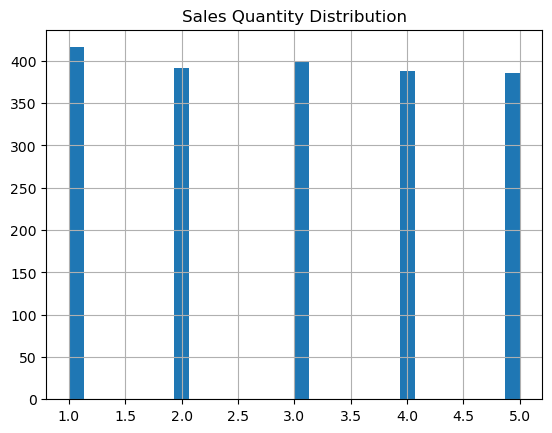

In [4]:
import matplotlib.pyplot as plt

# ターゲット変数の確認
df['quantity'].hist(bins=30)
plt.title("Sales Quantity Distribution")
plt.show()


## Findings
- quantity は 1〜5 の離散値に限られており、
取引単位での分布はほぼ均一であった。このため、単純な分布可視化からは需要の大小やばらつきに関する
有意な情報は得られなかった。
## Implications
- quantity をそのままターゲット変数として扱うのではなく、
店舗・商品カテゴリ・日単位で集約した指標や、
金額ベースの需要指標（売上高）を検討する必要がある。

In [5]:
print('店舗別売上の分布')
display(df.groupby("store_name")['quantity'].describe())

print('カテゴリ別売上の分布')
display(df.groupby("aisle")['quantity'].describe())


店舗別売上の分布


,count,mean,std,min,25%,50%,75%,max
store_name,,,,,,,,
City Fresh Store,235.0,2.931915,1.457240,1.0,2.0,3.0,4.0,5.0
Corner Grocery,218.0,3.032110,1.389187,1.0,2.0,3.0,4.0,5.0
FamilyFood Express,215.0,2.841860,1.401973,1.0,2.0,3.0,4.0,5.0
FreshMart Downtown,192.0,2.843750,1.398040,1.0,2.0,3.0,4.0,5.0
GreenGrocer Plaza,220.0,3.063636,1.389966,1.0,2.0,3.0,4.0,5.0
MegaMart Westside,214.0,3.074766,1.337090,1.0,2.0,3.0,4.0,5.0
QuickStop Market,208.0,2.980769,1.396896,1.0,2.0,3.0,4.0,5.0
SuperSave Central,232.0,3.004310,1.469746,1.0,2.0,3.0,4.0,5.0
ValuePlus Market,221.0,2.900452,1.504251,1.0,1.0,3.0,4.0,5.0


カテゴリ別売上の分布


,count,mean,std,min,25%,50%,75%,max
aisle,,,,,,,,
Bakery,182.0,2.890110,1.440922,1.0,2.0,3.0,4.0,5.0
Beverages,195.0,3.076923,1.460557,1.0,2.0,3.0,4.5,5.0
Canned Goods,190.0,3.026316,1.438084,1.0,2.0,3.0,4.0,5.0
Dairy,164.0,3.091463,1.426369,1.0,2.0,3.0,4.0,5.0
Frozen Foods,188.0,2.787234,1.398030,1.0,2.0,3.0,4.0,5.0
Health & Wellness,183.0,2.918033,1.341990,1.0,2.0,3.0,4.0,5.0
Household Items,175.0,2.908571,1.382437,1.0,2.0,3.0,4.0,5.0
Meat & Seafood,161.0,3.049689,1.430914,1.0,2.0,3.0,4.0,5.0
Personal Care,192.0,3.000000,1.482887,1.0,2.0,3.0,4.0,5.0


## Findings
- FreshMart Downtownは他の店舗に比べるとサンプル数がやや少なめ
- カテゴリ別、店舗別ともにmean≒medianとなっており安定した売れ方をしていると考えられる
- quantity は店舗差・カテゴリ差・施策差を表現するには解像度が低いと考えられる
## Implications
- 本データにおける quantity は 1〜5 の離散値に制限されており、
店舗や商品カテゴリ間の需要差を十分に表現できないことが分かった。
そのため、日 × 店舗 × 商品カテゴリ単位で集約した指標や、
売上金額ベースの需要指標を用いた分析が必要である。

,count,mean,std,min,25%,50%,75%,max
total_amount,1980.0,45.902576,35.018599,1.01,18.00,37.130,67.9300,149.90
discount_amount,1980.0,4.469591,4.962001,0.00,1.24,3.045,5.4025,29.94
final_amount,1980.0,41.432985,32.593328,-3.43,15.80,32.820,60.8000,147.91


total_amount         0
discount_amount    340
final_amount        13
dtype: int64

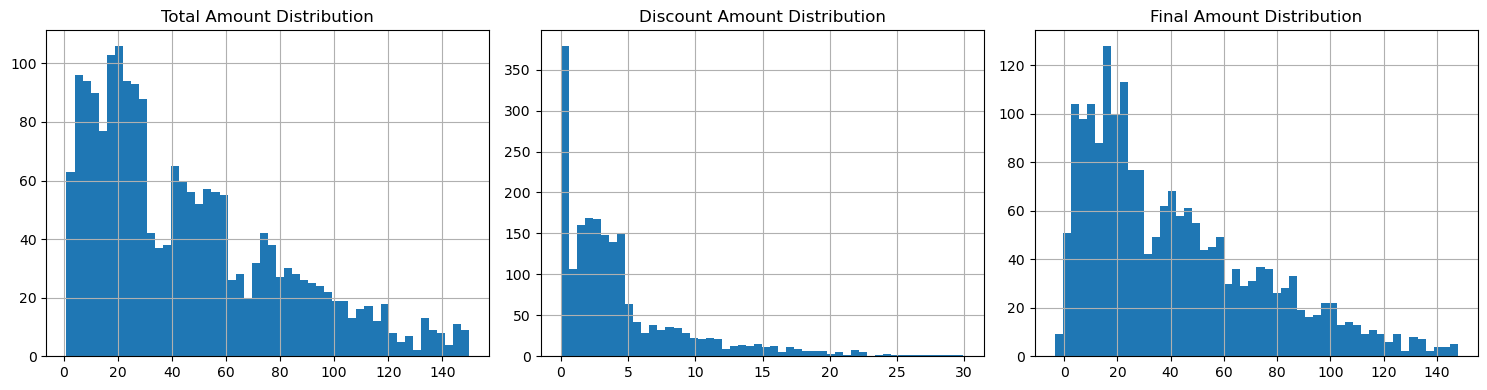

unique dates: 689


1    1915
2      20
Name: count, dtype: int64

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 日付型変換（EDA用：安全・可逆)
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

# 売上金額系の基本確認
display(df[["total_amount", "discount_amount", "final_amount"]].describe().T)

# 負の値・ゼロの確認
display((df[["total_amount", "discount_amount", "final_amount"]] <= 0).sum())

# 分布確認 
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

df["total_amount"].hist(bins=50, ax=axes[0])
axes[0].set_title("Total Amount Distribution")

df["discount_amount"].hist(bins=50, ax=axes[1])
axes[1].set_title("Discount Amount Distribution")

df["final_amount"].hist(bins=50, ax=axes[2])
axes[2].set_title("Final Amount Distribution")

plt.tight_layout()
plt.show()

# 日付粒度・重複確認
print("unique dates:", df["transaction_date"].nunique())

dup_check = (
    df.groupby(["transaction_date", "store_name", "aisle"])
      .size()
      .value_counts()
      .sort_index()
)
display(dup_check)


## Findings
- discount_amount が 0 の取引は全体の約17%であり、多くの取引で割引が適用されている
- final_amountでは0または負の値が少数確認できる。
- total_amount・discount_amount・final_amount はいずれも右に歪んだ分布を示しており、平均値が中央値を上回っている。
- このデータは ほぼ日 × 店舗 × 商品カテゴリ単位だが、一部に複数取引が存在するため、分析時には集約を前提とした設計が必要である可能性がある。
## Implications
- uantity は需要や施策効果の違いを表現するには解像度が低く、売上金額ベースの指標をターゲット変数として用いる方が適切であると考えられる。
- final_amount に一部負の値が含まれるため、前処理段階でその扱いを検討する必要がある。
- 日 × 店舗 × 商品カテゴリ単位での集約を前提とした分析設計が適していると考えられる。
